# Encontro 8: Centro e Periferia
## Raphael Costa e Frederico Curti

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from copy import deepcopy

import socnet as sn

from scipy.stats.stats import pearsonr
from scipy.optimize import minimize

%matplotlib inline


In [2]:
# LOAD RAW DATA INTO dict g
def load_graph(path):
    graph = sn.load_graph(path)
    print(path, 'finished loading')
    return graph
    
futures = []
with ProcessPoolExecutor(max_workers=4) as ppe:
    for i in range(40):
        path = f'./graphs/{1930+i}.gml'
        s = ppe.submit(load_graph, path)
        futures.append(s)

graphs = {}

for i in range(40):
    graphs[f"{1930 + i}"] = futures[i].result()

print("Done loading")

./graphs/1933.gml finished loading
./graphs/1932.gml finished loading
./graphs/1931.gml finished loading
./graphs/1930.gml finished loading
./graphs/1934.gml finished loading
./graphs/1935.gml finished loading
./graphs/1936.gml finished loading
./graphs/1937.gml finished loading
./graphs/1938.gml finished loading
./graphs/1939.gml finished loading
./graphs/1940.gml finished loading
./graphs/1941.gml finished loading
./graphs/1942.gml finished loading
./graphs/1943.gml finished loading
./graphs/1944.gml finished loading
./graphs/1945.gml finished loading
./graphs/1948.gml finished loading
./graphs/1947.gml finished loading
./graphs/1946.gml finished loading
./graphs/1949.gml finished loading
./graphs/1951.gml finished loading
./graphs/1952.gml finished loading
./graphs/1950.gml finished loading
./graphs/1953.gml finished loading
./graphs/1954.gml finished loading
./graphs/1955.gml finished loading
./graphs/1956.gml finished loading
./graphs/1957.gml finished loading
./graphs/1959.gml fi

In [3]:
# UTILITY FUNCTIONS
def remove_innovatless_years(g):
    useless_years = []
    g = deepcopy(g)
    for k,v in g.items():
        innovats = 0
        for n in range(len(v.nodes)):
            innovats += v.nodes[n]['innovats']
        if innovats == 0:
            useless_years.append(k)
    
    print('removed years:')
    print(useless_years)
    for y in useless_years:
        g.pop(y)
    
    return g

def trim(g):
    trimmed_graphs = deepcopy(g)
    for v in trimmed_graphs.values():
        for n in list(v.nodes):
            if v.nodes[n]['innovats'] == 0:
                v.remove_node(n)
                
    return trimmed_graphs

def cost(c, A):
    row = np.matrix(c)
    C = np.multiply(row.transpose(), row)
    correlation, _ = pearsonr(C.flat, A.flat)
    return -correlation

def write_coreness(g):
    g = g.copy()
    length = g.number_of_nodes()
    c = np.random.rand(length)
    A = sn.build_matrix(g)
    bounds = [(0, 1) for _ in range(length)]
    result = minimize(cost, c, args=(A,), bounds=bounds)
    norm = 0

    for i, n in enumerate(g.nodes):
        g.nodes[n]['coreness'] = result['x'][i]
        norm += g.nodes[n]['coreness'] ** 2

    for n in g.nodes:
        g.nodes[n]['coreness'] /= norm
    return g

In [4]:
## CORENESS CALCULATION ##
graphs = remove_innovatless_years(graphs)
graphs_trimmed = trim(graphs)

# for each graph spawn a new Process to calculate coreness
years = list(graphs_trimmed.keys())
futures = []
graphs_with_coreness = {}

with ProcessPoolExecutor(max_workers=4) as ppe:
    for k,v in graphs_trimmed.items():
        s = ppe.submit(write_coreness, v)
        futures.append(s)
        
for i in range(len(years)):
    graphs_with_coreness[years[i]] = futures[i].result()
    print(f"{i} ready!")

['1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1947', '1948', '1950', '1952', '1969']
0 ready!
1 ready!
2 ready!
3 ready!
4 ready!
5 ready!
6 ready!
7 ready!
8 ready!
9 ready!
10 ready!
11 ready!
12 ready!
13 ready!
14 ready!
15 ready!
16 ready!
17 ready!
18 ready!


## Inovação no Jazz: no Centro ou na Periferia?

Nesta atividade, vamos explorar onde surgem as inovações no Jazz. O período de análise inclui os anos 50 e 60 do século passado, quando músicos como Dave Brubeck e Miles Davis ficaram extremamente famosos. 

De onde vem as inovações? São tantas as possibilidades! Será que o artista genial tem uma personalidade distinta? Será que a estrutura neurológica de seu cérebro produz acordes dissonantes e improvisações geniais? Será que escutou uma britadeira quando era pequeno e com isso obteve inspiração para um novo ritmo? De que forma sua história de vida conta? É importante que seus pais tenham lhe incentivado? Será que é importante ter sido órfão e ganhar sustento como trombonista na bandinha da cidade?

São tantas as possíveis explicações! Possivelmente são infinitas as explicações e por isso nunca poderíamos ficar satisfeitos, certo? Errado: o trabalho científico precisa assumir que não conhecerá tudo sobre um fenômeno, mas ainda assim buscar o que for possível e relevante. Toda investigação científica necessita de alguma forma iniciar com o contexto, com as teorias conhecidas e delinear os principais mecanismos que se espera que estejam em operação para explicar o fenômeno.


### Scaffold 1: Entendimento do Contexto e Delineamento dos Mecanismos

Nesse estudo, tomaremos algumas decisões de redução do contexto para alguns mecanismos específicos. Em primeiro lugar, não nos importará a biografia do músico: não iremos ler a biografia de cada músico inovador. Ainda assim, poderemos em algum momento tentar capturar um pouco dessa história de vida a partir de variáveis como *gênero*, *idade*, *raça* e *local de nascimento*. De forma análoga, não iremos nos deter em variáveis que não podemos observar ou só podemos observar a alto custo, como a personalidade e minúcias da vida do artista.

A *localização* do artista pode ser extremamente interessante: será que é importante que o artista esteja tocando em Nova Iorque ou em Bruxelas? Sabemos que Nova Iorque foi e ainda é o principal centro de produção de Jazz no mundo. Então poderíamos também indagar se faria diferença verificar quais artistas frequentavam os principais clubes no SoHo, ou as sessões de improvisação no Harlem.

Mas por que assumimos que *geografia*, *espaço* e *local* são importantes? São importantes porque os artistas conhecem novos estilos ao encontrar face-a-face com outros músicos. Desta forma, são capazes de ter acesso direto a essas músicas, muito antes que alcancem as estações de rádio e os estúdios de gravação. A partir da ideia de que o contato direto entre os músicos é condição importante para a troca de informações, aprendizado mútuo, podemos dar um passo adicional e afirmar que o que realmente importa para um músico é a sua posição na rede de relacionamentos no mundo do Jazz.

A ideia de que inovação no jazz está relacionada com a posição do músico no mundo do Jazz é uma proposição interessante, mas ainda muito genérica para poder ser transformada em uma hipótese testável. A ideia de *posição* pode ser definida de muitas formas, pode estar associada a muitos mecanismos distintos, e pode ser operacionalizada de formas múltiplas. Possivelmente a intuição de posição é uma das mais populares em Análise de Redes Sociais e por isso o "mercado de ideias" sobre como definir essa intuição esteja tão abarrotado de propostas.

Entre as diversas possibilidades de entendimento do que significa posição, assumiremos um pressuposto importante: para caracterizar um indivíduo, precisamos pensar em qual *região* da rede ele pertence. Geralmente, em um mundo artístico, os padrões de relacionamento entre os músicos formam uma rede com um *centro* com membros altamente relacionados entre si e uma *periferia* na qual os membros se relacionam com o centro mas não entre si. Podemos observar esse fenômeno em outros contextos também: lembra da rede dos usuários que o Trump segue no Twitter? Vários *pundits* eram periféricos.

O surgimento de um centro se dá por várias razões, incluindo o *Efeito Mateus* que vimos na primeira aula no contexto de citações. Por motivos de simplificação, pensaremos em apenas duas regiões um centro e uma periferia, embora modelos mais complexos, como por exemplo modelos de múltiplos centros, sejam possíveis. Precisamos ainda de um pressuposto adicional: o centro de uma rede é onde o “burburinho” ocorre. Esses dois pressupostos são razoáveis: é plausível que o centro de uma rede seja onde haja mais densidade de relações, e também assumimos que mesmo que um indivíduo não seja particularmente bem conectado, basta que ele pertença ao centro para estar exposto a esse “caldo criativo”.

Entretanto, sem abandonar essa abordagem de “centro e periferia”, poderíamos também argumentar de forma plausível que inovações surgem na periferia do mundo do jazz em vez do centro. Se o sucesso comercial exige que os músicos centrais sigam certos padrões consagrados, apenas músicos periféricos são livres (Ou irrelevantes? Ou insignificantes?) o suficiente para testarem soluções novas. Eles não têm muito a perder, certo? 

Nos parágrafos acima exploramos o contexto do jazz e, de forma bastante informal, identificamos alguns mecanismos que poderiam explicar o surgimento de inovações. Na próxima seção, adotaremos uma abordagem mais formal para traduzir mecanismos a hipóteses.


### Scaffold 2: Tradução dos Mecanismos em Hipóteses

Músicos presentes no centro da rede têm mais acesso a outros músicos do jazz, e isso os leva a conhecer novos estilos de forma mais rápida. Esse acesso privilegiado possibilita o aprendizado mais rápido de novos estilos e rápida recombinação de elementos musicais. A recombinação de elementos musicais leva à emersão de novos estilos e inovações. Logo:

> Hipótese 1: músicos no centro da rede apresentam maiores chances de inovar

Em contrapartida, músicos na periferia tem menor pressão para se conformar aos padrões estabelecidos pela Indústria Fonográfica e pela comunidade de músicos. Desta forma, são mais livres para experimentar novas combinações artísticas. Assim:

> Hipótese 2: músicos na periferia da rede apresentam maiores chances de inovar

Eu sei o que vocês estão pensando: peraí, que migué é esse? Fazer um conjunto de hipóteses que cobrem todo o universo de possibilidades é fácil!

Mas não foi isso o que fizemos! Repare que:

* ambas as hipóteses são sustentadas por argumentos coerentes com o contexto apresentado; e
* elas **NÃO** cobrem todo o universo de possibilidades. Ambas podem estar erradas, por exemplo.

Mas eu concordo com uma coisa: a formulação ainda não está completa. Para estar completa, precisa de uma formalização do que é centro, uma formalização do que é periferia e uma formalização de que grandezas esperamos estar relacionadas.

Em dado momento, os professores vão fazer uma exposição sobre o conceito de *coreness*. Use o espaço abaixo para anotações.

<h4> Coreness é o parâmetro que estima a chance de um nó estar localizado em um centro </h4>

### Scaffold 3: Operacionalização e Teste das Hipóteses

Dados disponíveis:
* as redes cobrem os períodos de 1930 a 1969 e estão separados por ano;
* os nós são artistas e existe uma aresta entre dois artistas se eles participaram de uma mesma sessão de gravação;
* cada nó tem um atributo `sessions` que indica de quantas sessões ele participu e um atributo `innovats` que indica de quantas sessões *iovadoras* ele participou.
* cada aresta possui um peso que é inversamente proporcional ao tamanho das sessões.

### Verificando relação

**DADOS CRUS**

In [5]:
## Ver percentual removido RAW
df_raw = pd.DataFrame({
    'innovats': [],
    'sessions': [],
    'ips': [],
    'year': [],
})

for k, gr in graphs.items():
    ye = pd.DataFrame({
        'innovats': [gr.nodes[n]['innovats'] for n in gr.nodes],
        'sessions': [gr.nodes[n]['sessions'] for n in gr.nodes],
        'ips'     : [gr.nodes[n]['innovats']/gr.nodes[n]['sessions'] for n in gr.nodes],
        'year'    : [k for n in gr.nodes]
    })
    df_raw = df_raw.append(ye)
    
df_raw

,innovats,sessions,ips,year
0,0.0,5.0,0.0,1946
1,0.0,7.0,0.0,1946
2,0.0,6.0,0.0,1946
3,0.0,12.0,0.0,1946
4,0.0,1.0,0.0,1946
5,0.0,1.0,0.0,1946
6,0.0,8.0,0.0,1946
7,0.0,9.0,0.0,1946
8,0.0,11.0,0.0,1946
9,0.0,6.0,0.0,1946


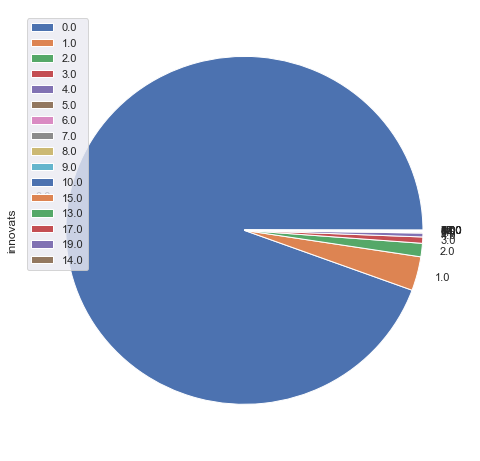

In [10]:
# AJUDA A CALCULAR
sns.set(rc={'figure.figsize':(8,8)})
df_raw.innovats.value_counts().plot(kind='pie', legend=True)

           innovats      sessions           ips
count  44103.000000  44103.000000  44103.000000
mean       0.104483      4.160987      0.018516
std        0.548259      5.275592      0.104302
min        0.000000      1.000000      0.000000
25%        0.000000      1.000000      0.000000
50%        0.000000      2.000000      0.000000
75%        0.000000      5.000000      0.000000
max       19.000000     87.000000      1.000000


          innovats     sessions          ips
count  4535.000000  4535.000000  4535.000000
mean      0.565380    16.609702     0.031923
std       1.365202     7.669812     0.075516
min       0.000000    10.000000     0.000000
25%       0.000000    11.000000     0.000000
50%       0.000000    14.000000     0.000000
75%       0.000000    19.000000     0.000000
max      19.000000    87.000000     0.727273


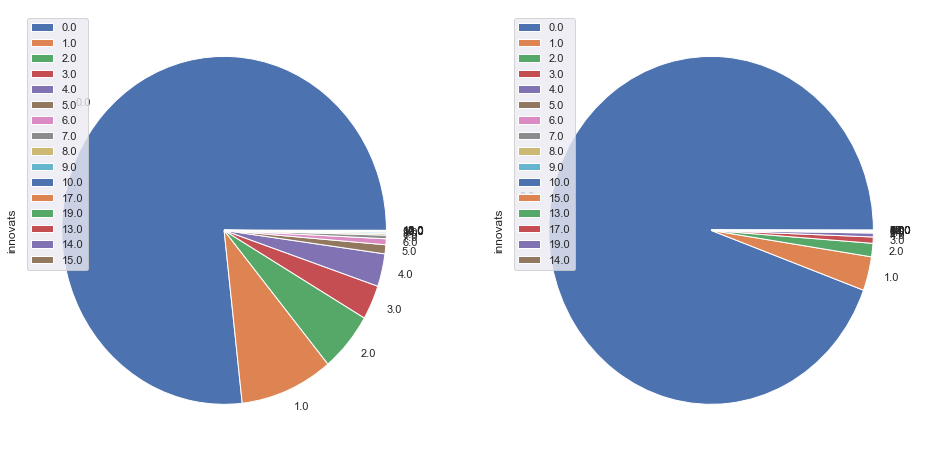

In [63]:
sns.set(rc={'figure.figsize':(16,8)})

# ct_si = pd.crosstab(df_raw.innovats, df_raw.sessions)
fig, axes = plt.subplots(nrows=1, ncols=2)
count_all = df_raw
count_with_innovats = df_raw[df_raw.sessions >= 10]

df_raw[df_raw.sessions >= 10].innovats.value_counts().plot(kind='pie', legend=True, ax=axes[0])
df_raw.innovats.value_counts().plot(kind='pie', legend=True, ax=axes[1])

print(count_all.describe())
print('\n')
print(count_with_innovats.describe())

In [31]:
df = pd.DataFrame({
    'coreness': [],
    'innovats': [],
    'sessions': [],
    'ips': [],
    'year': [],
})

for k, gr in graphs_with_coreness.items():
    year_df = pd.DataFrame({
        'coreness': [gr.nodes[n]['coreness'] for n in gr.nodes],
        'innovats': [gr.nodes[n]['innovats'] for n in gr.nodes],
        'sessions': [gr.nodes[n]['sessions'] for n in gr.nodes],
        'ips'     : [gr.nodes[n]['innovats']/gr.nodes[n]['sessions'] for n in gr.nodes],
        'year'    : [k for n in gr.nodes]
    })
    df = df.append(year_df)
    
# sns.relplot(data=data, x='coreness', y='innovats')
# sns.relplot(data=data, x='coreness', y='sessions')

False    2465
Name: sessions, dtype: int64

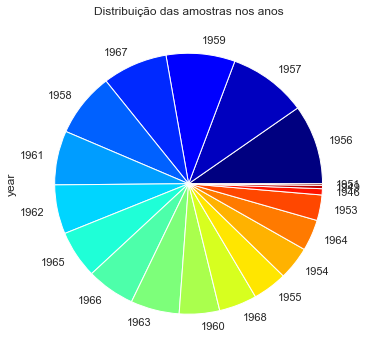

In [60]:
df.year.value_counts().plot(kind='pie', figsize=(6,6), cmap='jet', title='Distribuição das amostras nos anos')

/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0.41570562811790485


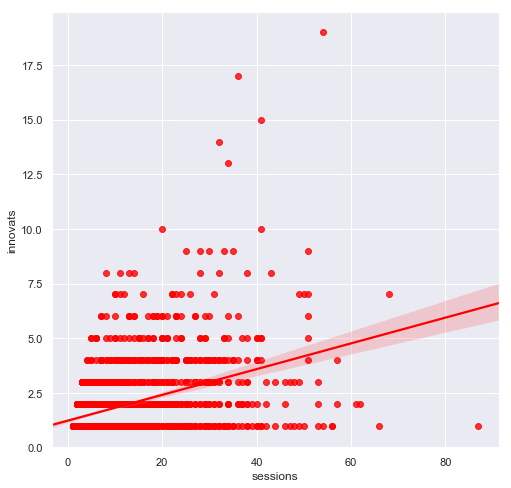

In [61]:
r = sns.regplot(data=df, x='sessions', y='innovats', color='red')
print(df['sessions'].corr(df['innovats']))

/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



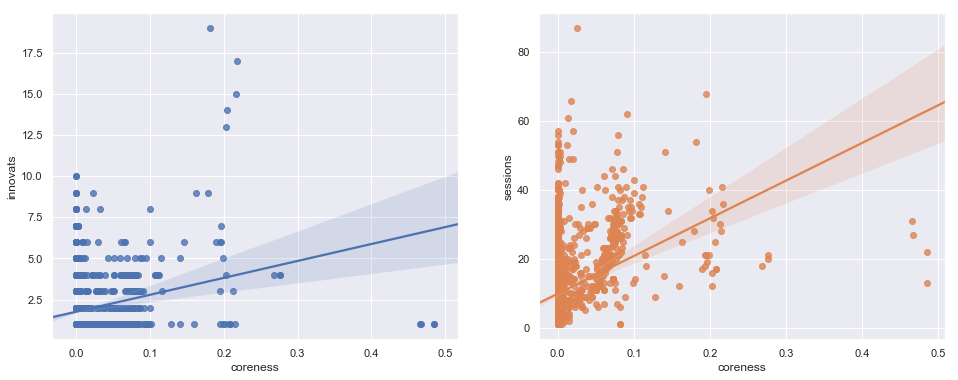

In [37]:
sns.set(rc={'figure.figsize':(16,6)})

# ct_si = pd.crosstab(df_raw.innovats, df_raw.sessions)
fig, axes = plt.subplots(nrows=1, ncols=2)
count_all = df_raw
count_with_innovats = df_raw[df_raw.innovats > 0]

sns.regplot(data=df, x='coreness', y='innovats', ax=axes[0])
sns.regplot(data=df, x='coreness', y='sessions', ax=axes[1])

Correlação entre IPS e coreness de todos os anos juntos


/Users/fredcurti/.virtualenvs/jupyter/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



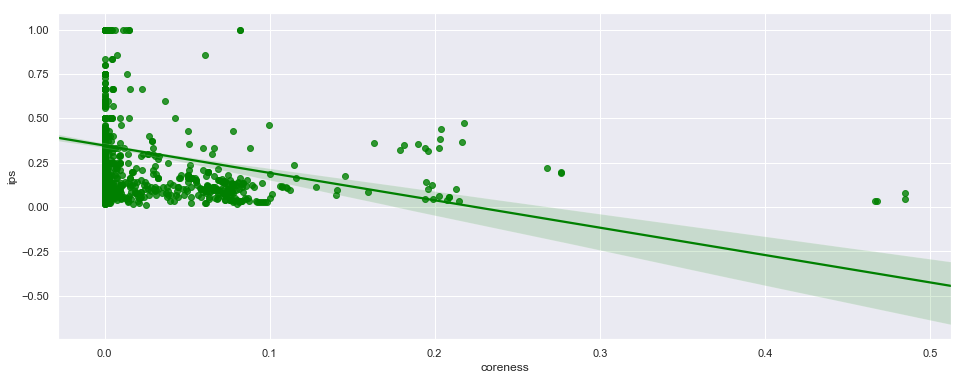

In [38]:
print("Correlação entre IPS e coreness de todos os anos juntos")
r = sns.regplot(data=df, x='coreness', y='ips', color='green')

-0.17731419971022191


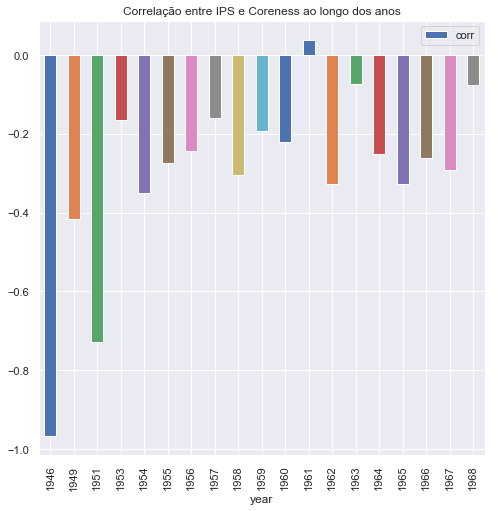

In [49]:
c_df  = df['ips'].corr(df['coreness'])
print(c_df)

corr_df = pd.DataFrame({
    'corr': [],
    'year': [],
})

for k, g in graphs_with_coreness.items():
    y = df[df.year == k]
    corr = y['ips'].corr(y['coreness'])
    
    corr_df = corr_df.append({'corr': corr, 'year': k }, ignore_index=True) 
    
corr_df.plot(kind='bar', x='year', y='corr', title="Correlação entre IPS e Coreness ao longo dos anos")


## Das análises à revisão da teoria

Muitas vezes, em um método científico lógico-dedutivo, geramos hipóteses que esperamos corroborar, e não estamos prontos para enfrentar resultados que fujam daquilo que é esperado. Por exemplo: deduzimos a hipótese de que a força da gravidade age de forma homogênea: corpos lançados simultaneamente de uma certa altura deverão cair na mesma velocidade. Se o experimento é “bem realizado”, obtemos o mesmo tempo de percurso de queda. Se os corpos chegam em momentos distintos, é possível que redesenhemos o experimento até acharmos o que esperamos. Por exemplo: se lançarmos uma bola de chumbo e uma folha de papel aberta de um prédio, é óbvio que a bola de chumbo chegará mais rápido. Mas fomos “treinados” a refazer o experimento e tomar algum objeto comparável à bola de chumbo, do que modelar a resistência do ar à folha de papel.

Entretanto, os resultados de um experimento ou de uma pesquisa podem “falhar” em corroborar as hipóteses desenvolvidas e dar pistas que nossa teoria não é completa. Esse é o final do ciclo de investigação científica e corresponde aos passos **4** (Interpretação dos resultados na linguagem de SNA) e **5** (Extrapolação/generalização dos resultados, reinterpretação do contexto, identificação de implicações e próximos passos) de nosso curso. Antes de definir e dar diretrizes para esses passos, oferecemos um exemplo de uma pesquisa que realizou esses últimos passos.

Nosso exemplo se inicia com a diferença entre “laços fortes” e “laços fracos”, uma das teorias centrais na Sociologia (ver Granovetter, 1977). Essa teoria traz as seguintes ideias conectadas:

1.	Há diferença entre “laços fracos” e “laços fortes”. “Laços fortes” são relacionamentos com as pessoas próximas, íntimas; “laços fracos”, em contraste, são relacionamentos onde o elemento “confiança” não é tão forte.

2.	É preciso confiança para confidenciar assuntos sérios.

3.	Logo, as pessoas confidenciam assuntos sérios com laços fortes.

A partir dessa estrutura “dedutiva”, a pesquisa de “capital social” cresceu e desenvolveu uma ampla gama de ferramentas e abordagens, incluindo a “Core Discussion Network” (CDN), que foi incluído no censo americano (Burt, 1984). Através dessa ferramenta, se pergunta “com quem você discute assuntos importantes” e através dessa pergunta se identifica as pessoas que são “laços fortes” do entrevistado. Com o tempo, passou-se a inverter a ordem:

1.	CDN explicita laços fortes.

2.	Laços fortes do CDN serão ativados para confidências de assuntos importantes.

Mario Luis Small (2013) investigou de que forma o CDN muda no tempo. Seu intuito inicial era apenas explorar de que forma as pessoas eram agregadas ou expulsas da rede de laços fortes identificada através do CDN. Entretanto, ele percebeu que havia algumas inconsistências:

* Nem todos os “assuntos importantes” eram realmente “confidências” (Bearman & Parigi, 2004). Por exemplo, falar sobre “política” (um assunto importante que nem sempre se abre para um colega do trabalho) é muito diferente de falar sobre “divórcio” (um assunto emocionalmente forte que implicava em um grau de intimidade e confiança muito alto).

* Nem sempre as pessoas confidenciavam assuntos realmente importantes com as pessoas próximas citadas no CDN. Muitas vezes, Small percebeu, as pessoas preferiam falar sobre a possibilidade de abandonar o doutorado com um doutorando mais ou menos desconhecido na mesa do bar do que falar sobre isso com os pais.

* Ou seja: é possível confidenciar assuntos importantes com “laços fracos” não incluídos no CDN.

Essa descoberta (passo **4** em nosso ciclo), trazia uma série de problemas para a teoria. Se é possível tomar um laço fraco como confidente, isso significa que não há diferença entre “laços fracos” e “laços fortes”? Um dos pilares da Sociologia parecia se instabilizar.

A partir desses achados, Mario Luis Small percebeu que havia sérias limitações na pesquisa (nosso passo **5**: extrapolação/generalização dos resultados, reinterpretação do contexto, identificação de implicações e próximos passos). Sabia-se que “laços fracos” eram eventualmente confidentes, mas não se sabia porque isso ocorria. Por isso, foi levado a realizar uma pesquisa qualitativa com vários doutorandos (Small, 2017). Ele descobriu que havia algumas circunstâncias que levavam os alunos a confidenciarem com “desconhecidos” ao invés de pessoas próximas:

* situações onde a pessoa próxima estava distante geograficamente;
* situações onde havia o risco de pessoas próximas falarem os segredos para outras pessoas próximas;
* situações onde as pessoas próximas não conheciam bem o assunto e isso poderia levar a conselhos ruins ou expectativas distorcidas.

Frente a essas situações, “estranhos” eram escolhidos quando:

* estavam disponíveis;
* conheciam o assunto e por isso poderiam dar conselhos relevantes;

Vemos um movimento de “ida e volta” do passo 5 à realização de uma nova pesquisa (passos 1 a 4), para obter-se novos resultados, até que as novas interpretações permitam a articulação dos achados em uma nova teoria mais geral. Voltando ao contexto dessa pesquisa, as novas descobertas não invalidam a teoria anterior, mas complementam.

O último ciclo quando ingressa no passo 5 traz a seguinte revisão à teoria:

* laços fortes ainda são utilizados para muitos temas importantes e confidências, mas não para todos os assuntos importantes e confidências. 
* as situações que exigem a confidência a estranhos são aquelas onde esses “confidentes” estão próximos, disponíveis e entendem do assunto em questão
* isso implica em uma escolha que é guiada por algum tipo de “cálculo” do indivíduo que busca se aconselhar

Podemos agora definir e explicitar o que ocorre nesses últimos passos. Para os três primeiros, vocês tiveram *scaffold*. Para estes dois últimos, terão que escrever e entregar!

### 4: Interpretação dos resultados na linguagem de SNA (Social Network Analysis)

A partir dos resultados obtidos das análises, descreva o que está acontecendo. Isso inclui explicitar:
•	quais hipóteses foram corroboradas
•	quais hipóteses foram rejeitadas
•	trazer análises suplementares que testem a robustez dos achados
•	Buscar situações onde as hipóteses corroboradas poderiam ser rejeitadas (condições de fronteira)
•	Identificar situações alternativas também que corroboram as hipóteses

Essa interpretação pode ser feita a partir da citação dos dados obtidos nas análises e não precisa ser “didática”. Basta um “de para” dos resultados às hipóteses originalmente elaboradas para guiar o leitor.

**Resposta:** 

Após análise dos dados disponíveis, não foi possível corroborar nenhuma das duas hipóteses sugeridas. Isso se deve ao fato de que a correlação entre Coreness e IPS, o parâmetro criado para indicar o "rendimento criativo" de um artista, demonstra uma relação muito fraca entre as duas variáveis.

Após análise superficial dos gráficos, aparentemente artistas com um coreness mais baixo apresentariam maior probabilidade de inovação. Porém, essa relação se provou errônea pois foi observado que a densidade de artistas com um coreness próximo a zero, ou seja, mais periférico, era muito maior, logo o número absoluto de inovações nessa região é maior, o que não significa que esses artistas possuem maior chance de inovar de fato. Para contornar esse problema, criamos o parâmetro IPS, que engloba duas variáveis para classificar o rendimento criativo de um artista. Esse parâmetro é simplesmente a razão entre o número de inovações(Innovats) e a quantidade de sessões inovadoras que o artista participou(Sessions). Para validar tal parâmetro, foi observada, inicialmente, a correlação entre Innovats e Sessions, que apresentou um valor positivo alto de <code>0.41570562811790485</code>. A partir da divisão dos atributos, seria observada a proporção de inovações feitas por artista para cada sessão,  o que indica um certo "rendimento criativo" para aquele artista. Assim, seria verificado onde um maior rendimento acontece, e, consequentemente, onde um artista tem mais chances de inovar.

Portanto, a partir do IPS e do coreness, foi efetuada a regressão entre tais parâmetros considerando todos os anos em que houveram ao menos uma inovação, ou seja, aqueles em que a soma total de inovações é maior de 0. Inicialmente observamos uma correlação negativa, o que indicaria que quanto mais ao centro um artista está, menor seria o seu IPS, logo, tal artista teria menos chance de inovar. Da mesma forma, um artista mais periférico apresentaria mais chance de inovar. No entanto o coeficiente de correlação encontrado para todos os anos em conjunto foi baixo: <code>-0.17731419971022191</code>, o que corresponde a uma intepretação de que a correlação seria bem fraca. Essa interpretação, no entanto, não ocorre em todos os anos observados. Em 1946, por exemplo, existe uma correlação negativa muito forte, enquanto em 1961 existiu a única correlação positiva, embora muito fraca. 

Por fim, devido ao fato de que a correlação varia muito de ano para ano e no geral possui interpretação muito fraca, não foi possível corroborar ou rejeitar nenhuma das hipóteses, de forma que o parâmetro coreness não apresentou influência significativa na chance de um artista inovar.

### 5: Extrapolação/generalização dos resultados, reinterpretação do contexto, identificação de implicações e próximos passos

A partir da interpretação técnica realizada, nesse passo se procede uma discussão do que isso significa à luz do que foi elaborado nos passos 1 e 2 originalmente:

* Por que houve hipóteses rejeitadas? Isso diz respeito ao contexto específico onde foram testadas?

* Há explicações alternativas ou motivos obscuros para algo acontecer que justificaria pesquisas futuras? Essas indagações remetem às limitações da pesquisa.

* Os achados permitem aprimorar a teoria? Por exemplo, na pesquisa citada, agregou-se situações específicas e a escolha individual que se origina na interpretação da situação e avaliação das alternativas existentes.

**Resposta:**
Para viabilizar a análise dos dados, por limitações técnicas envolvendo o processamento destes, foi necessário um parâmetro de corte da vasta base de dados original. Para essa análise, foram descartados os artistas que não apresentaram inovações em seus respectivos anos. Tal decisão foi efetuada a partir do princípio de que o objetivo da análise era mostrar em qual das regiões existiu maior chance de inovação, ou seja, onde o rendimento criativo era maior. Por isso faria mais sentido observar somente os artistas que inovaram ao menos uma vez, para então calcular sua localidade (o processo mais custoso de toda a análise) e as respectivas implicações desta. 

Talvez com uma análise mais profunda tal parâmetro de corte possa ser considerado equivocado. Por exemplo, de início foi considerado como parâmetro de corte o número de sessões inovadoras nas quais os artistas teriam participado, nos quais somente artistas que participaram de mais de dez sessões seriam considerados. Embora esse parâmetro removesse boa parte dos nós, facilitando muito o processamento, ele também removia por volta de metade das inovações da base como um todo, alterando drasticamente a média do IPS quando comparado à base íntegra ( de <code> 0.018516 </code> para <code> 0.031923 </code> ) 

Uma possível reinterpretação do contexto pode ajudar-nos a entender, ou ao menos, justificar parte dos resultados obtidos nessa análise. Como já foi explicitado, artistas periféricos apresentaram consistentemente maior chance de inovação do que artistas centrais na rede. Isso pode ter ocorrido devido à algumas circunstâncias históricas presentes na cena do Jazz nos EUA no período observado. Por volta dos anos 50, no período pós segunda guerra, começaram a surgir novas formas de entretenimento em território norte-americano. A televisão, por exemplo, ajudou a introduzir e popularizar novos estilos musicais que despontaram nas décadas subsequentes, como o Rock nos anos 60, ilustrado pelo sucesso de Elvis, e o Disco nos anos 70. Essas mudanças, aliadas ao período chamado de depressão pós guerra, provocaram diversas mudanças no cenário do Jazz: Grandes bandas de Jazz Clássico se desfizeram e artistas renomados (centrais) migraram para outros gêneros musicais em busca de se manterem relevantes. Essas mudanças criaram um espaço para que novos artistas se aventurassem na cena do Jazz e consequentemente se tornassem protagonistas da inovação no gênero. 

Os achados permitem aprimorar a teoria de modo que mesmo uma conclusão que não rejeite as hipóteses originais descarte estas do universo de possibilidades para explicar o fenômeno, a fim de que uma próxima análise valha-se dos estudos anteriores, com um leque de hipóteses mais restrito. Nesse caso específico, uma análise futura talvez não considere o coreness um parâmetro fundamental para explicar o surgimento de inovações no jazz, ou ao menos atribuir um peso menor à ele. Além disso, poderão ser analisadas outras características que remetem à reinterpretação do contexto, com a aquisição de novos dados como a mudança de gêneros musicais dos artistas e a influência de outros gêneros no comportamento da rede.


## Referências

Bearman, P., & Parigi, P. (2004). Cloning headless frogs and other important matters: Conversation topics and network structure. Social Forces, 83(2), 535-557.

Burt, R. S. (1984). Network items and the general social survey. Social networks, 6(4), 293-339.

Granovetter, Mark S. "The strength of weak ties." Social networks. 1977. 347-367.

Small, M. L. (2013). Weak ties and the core discussion network: Why people regularly discuss important matters with unimportant alters. Social networks, 35(3), 470-483.

Small, M. L. (2017). Someone to Talk to. Oxford University Press.

### Observações

A tabela usada para determinar a interpretação do coeficiente de correlação foi a seguinte:
<br>
<img src='./tabela.png'/><br>
Fonte: http://leg.ufpr.br/~silvia/CE003/node74.html